In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import torch
torch.manual_seed(0)

%load_ext autoreload 
%autoreload 2
%config InlineBackend.figure_format = 'retina'

/home/gridsan/mmurphy/.conda/envs/HumanProteinAtlas/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
embeddings = np.load('./data/embeddings.npy')
index = !cat './data/embeddings.txt'
embeddings = pd.DataFrame(embeddings,index=index)
df = pd.read_csv('./data/hpa_v21_kidney.csv',index_col=0)
rna = pd.read_csv('./data/rna.csv',index_col=0)

In [3]:
adata = embeddings.join(df)
adata = sc.AnnData(adata[embeddings.columns], obs=adata[df.columns])
adata.var_names = pd.Series(range(adata.shape[1])).astype(str)
adata.obs = adata.obs.join(rna, on='Gene', how='left')
adata.obs['rna_cell_type'] = adata.obs[rna.columns].idxmax(1)
adata.obs['rna_specificity'] = adata.obs[rna.columns].max(1)

adata

AnnData object with n_obs × n_vars = 10164 × 128
    obs: 'Batch', 'Slide', 'Well', 'Tissue', 'Gene name', 'Gene', 'UniProt', 'Antibody', 'nTPM', 'Staining', 'Sex', 'Age', 'Patient', 'URL', 'Level', 'Reliability', 'epithelial cell of proximal tubule', 'fibroblast', 'glomerular visceral epithelial cell', 'kidney capillary endothelial cell', 'kidney connecting tubule epithelial cell', 'kidney distal convoluted tubule epithelial cell', 'kidney loop of Henle thick ascending limb epithelial cell', 'leukocyte', 'mesangial cell', 'parietal epithelial cell', 'renal alpha-intercalated cell', 'renal beta-intercalated cell', 'renal principal cell', 'rna_cell_type', 'rna_specificity'

In [4]:
sc.pp.neighbors(adata, use_rep='X')
sc.tl.umap(adata, min_dist=0.5)

In [5]:
cell_type_colors = {
    'glomerular visceral epithelial cell':plt.get_cmap('Reds')(0.9),
    'mesangial cell':plt.get_cmap('Reds')(0.8),
    'parietal epithelial cell':plt.get_cmap('Reds')(0.7),
    'kidney capillary endothelial cell':plt.get_cmap('Reds')(0.6),
    'leukocyte':plt.get_cmap('Reds')(0.5),
    #
    'fibroblast':'orange',
    #
    'epithelial cell of proximal tubule':plt.get_cmap('Greens')(0.8),
    #
    'kidney loop of Henle thick ascending limb epithelial cell':plt.get_cmap('Blues')(0.9),
    'kidney distal convoluted tubule epithelial cell':plt.get_cmap('Blues')(0.7),
    'kidney connecting tubule epithelial cell':plt.get_cmap('Blues')(0.5),
    #
    'renal alpha-intercalated cell':plt.get_cmap('Purples')(0.9),
    'renal beta-intercalated cell':plt.get_cmap('Purples')(0.7),
    'renal principal cell':plt.get_cmap('Purples')(0.5),
}

adata.obs['rna_cell_type'] = ( adata.obs['rna_cell_type']
                                    .astype('category')
                                    .cat
                                    .reorder_categories(list(cell_type_colors)) )

... storing 'Well' as categorical
... storing 'Tissue' as categorical
... storing 'Gene name' as categorical
... storing 'Gene' as categorical
... storing 'UniProt' as categorical
... storing 'Antibody' as categorical
... storing 'Staining' as categorical
... storing 'Sex' as categorical
... storing 'Level' as categorical
... storing 'Reliability' as categorical


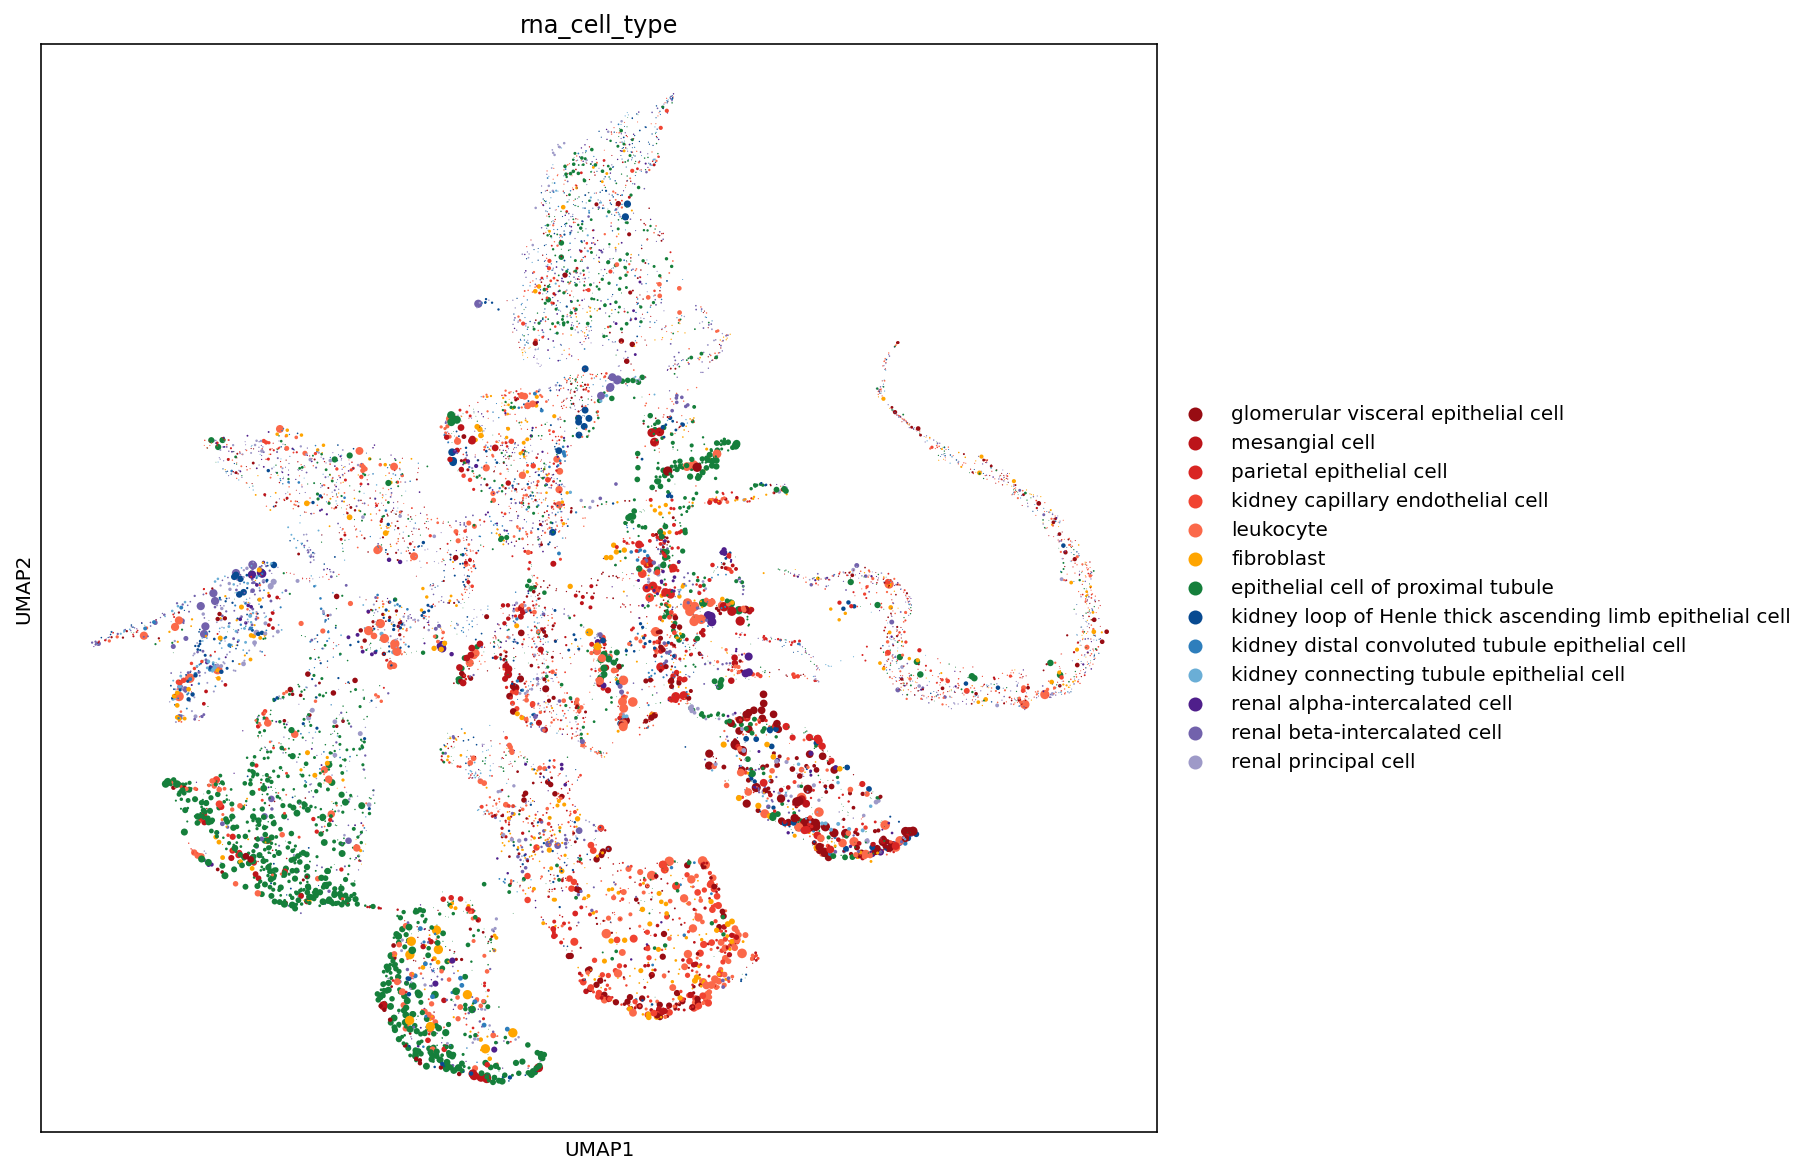

In [6]:
fig, ax = plt.subplots(figsize=(10,10))
sc.pl.umap(
    adata, 
    color=['rna_cell_type'], 
    palette=cell_type_colors, 
    ax=ax, 
    s=adata.obs['rna_specificity']**2*100,
    na_in_legend=False
)

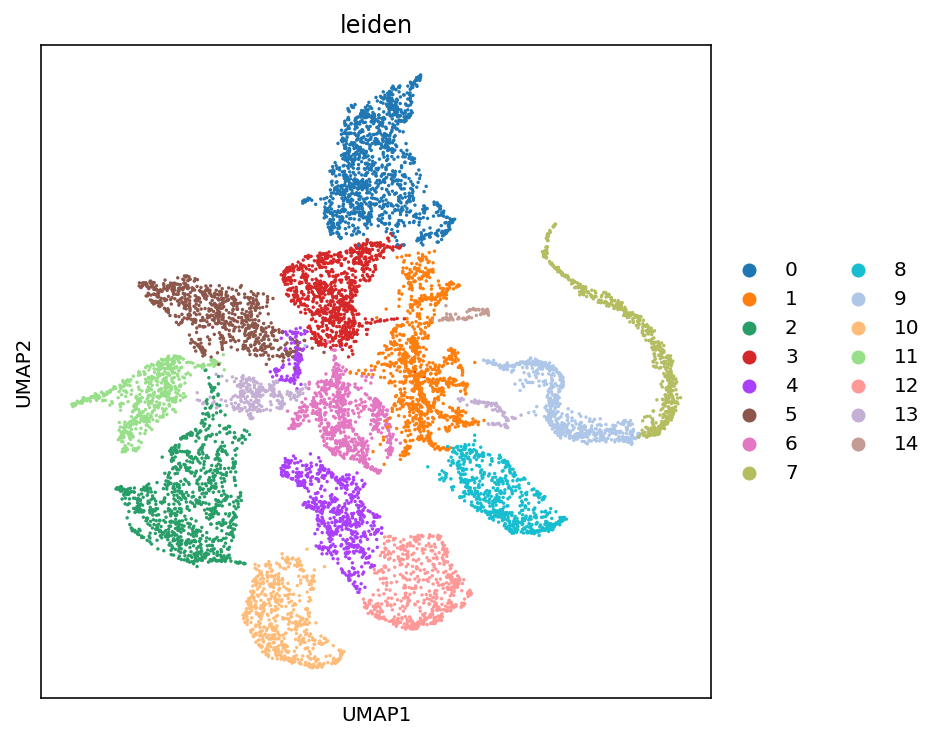

In [7]:
sc.tl.leiden(adata, resolution=0.2)

sc.pl.umap(adata, color='leiden', ax=plt.subplots(figsize=(6,6))[1])

... storing 'Patient' as categorical


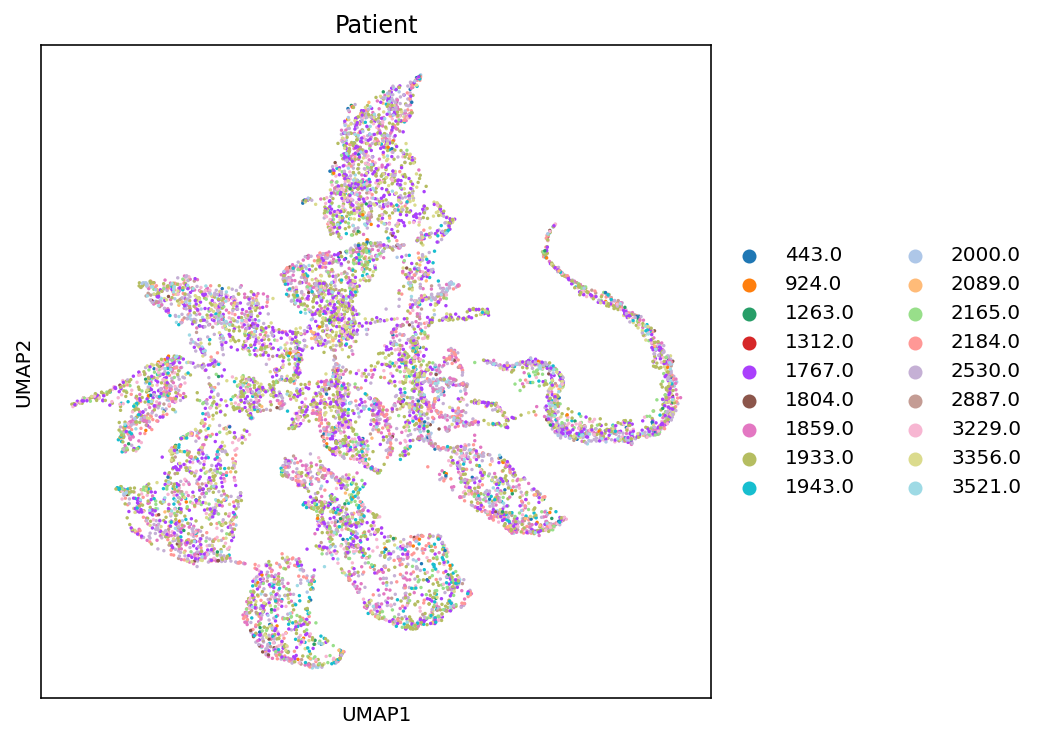

AMI between Leiden cluster and donor 0.011856320956474072


In [8]:
from sklearn.metrics import adjusted_mutual_info_score

adata.obs['Patient'] = adata.obs['Patient'].astype(str)
sc.pl.umap(adata,color=['Patient'],ax=plt.subplots(figsize=(6,6))[1])

ami = adjusted_mutual_info_score(
    adata.obs['leiden'], 
    adata.obs['Patient']
)
print('AMI between Leiden cluster and donor', ami)

In [9]:
adata.write('./data/adata.h5')